# Weight Visualization Examples - Rough

This notebook is a companion to this google doc: https://docs.google.com/document/d/1a3z4Rwup1KVYS_GXjy48Lfim-4x-a_z5vhK7CvF3QKE/edit#

# Setup

You can ignore this section

In [ ]:
%tensorflow_version 1.x
!pip install --quiet --upgrade-strategy=only-if-needed git+https://github.com/tensorflow/lucid.git

TensorFlow 1.x selected.


In [ ]:
# Imports

import functools

import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show, collapse_channels
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.scratch.parameter_editor import ParameterEditor
from lucid.misc.channel_reducer import ChannelReducer
from lucid.misc.gradient_override import gradient_override_map
from lucid.misc.io.showing import _image_url, _display_html

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


# Utilities

You can ignore this section on a first pass. Understanding `get_expanded_weights()` is worthwhile later if you want to understand these ideas deeply.

In [ ]:
def ForceAvgPoolGrad(op, grad):
    inp = op.inputs[0]

    op_args = [op.get_attr("ksize"), op.get_attr("strides"), op.get_attr("padding")]
    smooth_out = tf.nn.avg_pool(inp, *op_args)
    inp_smooth_grad = tf.gradients(smooth_out, [inp], grad)[0]

    return inp_smooth_grad

def MaxAsAvgPoolGrad(op, grad):
    inp = op.inputs[0]

    op_args = [op.get_attr("ksize"), op.get_attr("strides"), op.get_attr("padding")]
    smooth_out = tf.nn.avg_pool(inp, *op_args)
    inp_smooth_grad = tf.gradients(smooth_out, [inp], grad)[0]

    return inp_smooth_grad

@functools.lru_cache(128)
def get_expanded_weights(model, layer1, layer2, W=5):

  """Get the "expanded weights" between two layers.

  Arguments:
    model: model to get expanded weights from
    layer1: earlier layer to expand weights between
    layer2: later layer to expand weights between
    W: spatial width of expanded weigths

  Returns:
    Expanded weights as numpy array of shape 
    [W, W, layer1 channels, layer2 chanels]


  Discussion:

  Sometimes the meaningful weight interactions are between neurons which aren’t 
  literally adjacent in a neural network, or where the weights aren’t directly 
  represented in a single weight tensor. A few examples:

  * In a residual network, the output of one neuron can pass through the 
    additive residual stream and linearly interact with a neuron much later 
    in the network.
  * In a separable convolution, weights are stored as two or more factors, 
    and need to be expanded to link neurons.
  * In a bottleneck architecture, neurons in the bottleneck may primarily be 
    a low-rank projection of neurons from the previous layer.
  * The behavior of an intermediate layer simply doesn’t introduce much 
    non-linear behavior, leaving two neurons in non-adjacent layers with a 
    significant linear interaction.

  As a result, we often work with “expanded weights” -- that is, the result 
  of multiplying adjacent weight matrices, potentially ignoring non-linearities. 
  We generally implement expanded weights by taking gradients through our model, 
  ignoring or replacing all non-linear operations with the closest linear one.

  These expanded weights have the following properties:

  * If two layers interact linearly, the expanded weights will give the true 
    linear map, even if the model doesn’t explicitly represent the weights in a 
    single weight matrix.
  * If two layers interact non-linearly, the expanded weights can be seen as 
    the expected value of the gradient up to a constant factor, under the 
    assumption that all neurons have an equal (and independent) probability of 
    firing.

  They also have one additional benefit, which is more of  an implementation 
  detail: because they’re implemented in terms of gradients, you don’t need to 
  know how the weights are represented. For example, in TensorFlow, you don’t 
  need to know which variable object represents the weights. This can be a 
  significant convenience when you’re working with unfamiliar models!
  
  """

  # Set up a graph for doing attribution...
  with tf.Graph().as_default(), tf.Session(), gradient_override_map({"Relu": lambda op, grad: grad, "MaxPool": MaxAsAvgPoolGrad}):
    t_input = tf.placeholder_with_default(tf.zeros([1,224,224,3]), [None,None, None, 3])
    T = render.import_model(model, t_input, t_input)

    # Compute activations; this gives us numpy arrrays with the right number of channels
    acts1 = T(layer1).eval()
    acts2 = T(layer2).eval()

    # Compute gradient from center; due to overrides this just multiplies out the weights
    t_offset = (tf.shape(T(layer2))[1]-1)//2
    t_center = T(layer2)[0, t_offset, t_offset]
    n_chan2 = tf.placeholder("int32", [])
    t_grad = tf.gradients(t_center[n_chan2], [T(layer1)])[0]
    arr = np.stack([t_grad.eval({n_chan2: i, T(layer1): acts1[:,0:W,0:W]})[0] for i in range(acts2.shape[-1])], -1)

    return arr

In [ ]:
H = lambda S : int(S, 16)/255.
C = lambda X: np.asarray([H(X[0:2]), H(X[2:4]), H(X[4:6])])

def weight_color_scale(x):
  if x < 0:
    x = -x
    if x < 0.5:
      x = x*2
      return (1-x)*C("f7f7f7") + x*C("92c5de")
    else:
      x = (x-0.5)*2
      return (1-x)*C("92c5de") + x*C("0571b0")
  else:
    if x < 0.5:
      x = x*2
      return (1-x)*C("f7f7f7") + x*C("f4a582")
    else:
      x = (x-0.5)*2
      return (1-x)*C("f4a582") + x*C("ca0020")

weight_heatmap = lambda X: np.asarray([[weight_color_scale(x) for x in X_] for X_ in X])

In [ ]:
def precomputed_featurevis_html(layer_name, n, W=None):

  W_dict = {"mixed3a": 60, "mixed3b" : 60, "mixed4a": 100, "mixed4b" : 110, "mixed4c" : 120, "mixed4d" : 130}
  if W is None:
    if W in W_dict:
      W = W_dict
    else:
      W=60


  img_url = "https://storage.googleapis.com/inceptionv1-weight-explorer/images/neuron/%s_%s.jpg" % (layer_name, n)
  img = "<img  src='%s'>" % (img_url)
  a_url =  "https://storage.googleapis.com/inceptionv1-weight-explorer/%s_%s.html" % (layer_name, n)
  img = "<a href='%s'>%s</a>" % (a_url, img)

  return img

In [ ]:
def neuron_with_weight(layer, unit, W):
  width_dict = {"mixed3a": 60, "mixed3b" : 60, "mixed4a": 100, "mixed4b" : 110, "mixed4c" : 120, "mixed4d" : 130, "mixed4e" : 130, "mixed5a" : 150, "mixed5b" : 150}
  if layer in width_dict:
    width = width_dict[layer]
  else:
    width=60
  if width < 70:
    width = 70

  assert W.min() >= -1.01 and W.max() <= 1.01
  if len(W.shape) == 2:
    W_img = weight_heatmap(W)
  else:
    W_img = W
  url = _image_url(W_img, domain=(0,1))

  return f"""
      <div style="display: inline-block; margin-right: 2px; margin-bottom: 4px;">
        <div style="image-rendering:pixelated; display: flex; flex-direction: column;">
        {precomputed_featurevis_html(layer, unit, W=width)}
        <img src="{url}" style="width:{width-2}px; height: {width-2}px;" class="weight">
        </div>
      </div>
    """

def neuron_with_weight_row(layer, units, W):
  inner_html = " ".join(
      neuron_with_weight(layer, n, W[..., n])
      for n in units)
  return f"""<div style="width: 5000px; margin-top: 2px;">{inner_html}</div>"""

def neuron_with_weight_row_preselected(layer, units, W):
  inner_html = " ".join(
      neuron_with_weight(layer, n, W[i])
      for i, n in enumerate(units))
  return f"""<div style="width: 5000px; margin-top: 2px;">{inner_html}</div>"""

# Visualization Examples

In [ ]:
model = models.InceptionV1()

## Visualizing the first layer

Before we look into complicated cases of visualizing weights, it's worth considering the easy and commonly used case of visualizing the first layer.

In [ ]:
# There are two ways to acces weights.
# The first is to just dig through weight variables wiht ParameterEditor
# This has the advantagee of also allowing weight/circuit editing.

params = ParameterEditor(model.graph_def)
W_inp_0 = params['conv2d0_w']

show(0.5+0.5*W_inp_0[..., 0]/W_inp_0.max(), w=128)

# Or one can use get_expanded_weights()
# This doesn't require you to know variable names, just layers, and can 
# give the expanded weights across multiple layers.
# However, you need to determine the correct width and sometimes you need to
# give extra space if there's striding or such

W_inp_0_alt = get_expanded_weights(model, "input", "conv2d0", W=8)

# Even though this is a 7x7 convolution, we needed to extarct an 8x8 due to the
# way strdiding aligned. The extra positions are 0

show(0.5+0.5*W_inp_0_alt[..., 0]/W_inp_0_alt.max(), w=128*(8/7.))

In [ ]:
# A nice trick trick for visualizing the first conv layer is to sort them by
# the first PCA of the second conv layer weights.

conv2d0_ordering = np.argsort(ChannelReducer(1, "PCA").fit_transform(
    np.abs(params["conv2d1_w"])[0,0])[:,0])

def show_ws(ns, labels=None, weights=None):
  print(ns)
  ns = list(ns)
  W = params['conv2d0_w'].transpose(3,0,1,2)
  if weights is not None:
    W_ = W[ns]*weights[:, None, None, None]
  else:
    W_ = W[ns]
  # turn weights into images with grey as zero, dark as negative, light as positive
  show(0.5+0.05*W_/np.abs(W[ns]).max(axis=(1,2,3), keepdims=True)+0.45*W_/np.abs(W).max(), w=64, labels=labels or [str(n) for n in ns])
  

for i in range(0,64,16):
  show_ws(conv2d0_ordering[range(i, i+16)])

[17 10 54  0  3 14 62 45 15 41 49 46 39  1 22 27]


[28 18 57 53  6 19  9 43 30  4 44  8 26 21  2 60]


[20 56 63 42 16 61 52 31 25 12 55  7 35 51 40 24]


[29 23 59 48 58  5 11 32 13 37 36 38 33 50 34 47]


## Simple visualizations of hidden-hidden weights

Understanding hidden layers is different -- in order to really understand what’s going on, we need to contextualize weights in the broader context of the network. 

In [ ]:
W_3a_3b = get_expanded_weights(model, "mixed3a", "mixed3b")

In [ ]:
# Weight visualization without context. Not that helpful.

show(weight_heatmap(W_3a_3b[:,:,147,379] / W_3a_3b[:,:,:,379].max()), w=128)

In [ ]:
# Weight visualization with context -- we can see that this is connecting 
# together two curve detectorrs!

_display_html(precomputed_featurevis_html("mixed3a", 147))
show(weight_heatmap(W_3a_3b[:,:,147,379] / W_3a_3b[:,:,:,379].max()), w=128)
_display_html(precomputed_featurevis_html("mixed3b", 379))

In [ ]:
# Let's look at the top connections for this neuron.

_display_html(precomputed_featurevis_html("mixed3b", 379))
print ("\nweights to previous layer:\n")

top_connected_neurons = np.argsort([-np.linalg.norm(W_3a_3b[:, :, i, 379]) for i in range(W_3a_3b.shape[-2])])[:10]
_display_html(neuron_with_weight_row("mixed3a", list(top_connected_neurons), W_3a_3b[..., 379] / np.abs(W_3a_3b[..., 379]).max()))


weights to previous layer:



In [ ]:
# We can also look at it's top uses in the next layer.

# maxpool4 = maxpool(mixed3b) - use it instead to avoid distortion of weights.
W_3b_4a = get_expanded_weights(model, "maxpool4", "mixed4a")

_display_html(precomputed_featurevis_html("mixed3b", 379))
print ("\nweights to next layer:\n")

top_connected_neurons = np.argsort([-np.linalg.norm(W_3b_4a[:, :, 379, i]) for i in range(W_3b_4a.shape[-1])])[:10]
_display_html(neuron_with_weight_row("mixed4a", list(top_connected_neurons), W_3b_4a[..., 379, :] / np.abs(W_3b_4a[..., 379, :]).max()))


weights to next layer:



## Visualization Weight Spatial Positions

Recall that the weights for a single neuron have shape `[width, height, input_channels]`. In the previous section we split up input_channels and visualized each `[width, height]` matrix. But an alternative approach is to think of there as being a vector over input neurons at each spatial position, and to apply feature visualization to each of those vectors. You can think of this as telling us what the weights in that position are collectively looking for.

In [ ]:
def vis_vecs(layer, W, vecs, cossim_pow=0, n_steps=512):
  vecs_flat = vecs.reshape([-1, vecs.shape[-1]])
  param_f = lambda: param.image(W, batch=vecs_flat.shape[0])

  obj = objectives.Objective.sum([
      objectives.direction_neuron(layer, vec, batch=n, cossim_pow=cossim_pow)
      for n, vec in enumerate(vecs_flat.astype("float32"))
  ])
  
  imgs = render.render_vis(model, obj, param_f, thresholds=(n_steps,))
  
  return imgs[0].reshape(list(vecs.shape[:-1]) + [W,W,3])

In [ ]:
def build_img_grid(imgs, mags=None, pad=((0,0), (0,0))):
  W = imgs.shape[0]
  W2 = imgs.shape[2]
  
  imgs = imgs.reshape([W,W,W2,W2,3])
  if mags is not None:
    mags = mags.reshape([W,W,1,1,1]) / mags.max()
    imgs = imgs*mags + 0.9*(1-mags)
  
  imgs_ = np.pad(imgs, list(pad) + [(0,0), (0,0), (0,0)],
                 mode='constant', constant_values=(0.9,))
  imgs_ = np.pad(imgs_, [(0,0), (0,0), (0,1), (0,1), (0,0)],
                 mode='constant', constant_values=(1,))
  
  return np.hstack(np.hstack(imgs_))


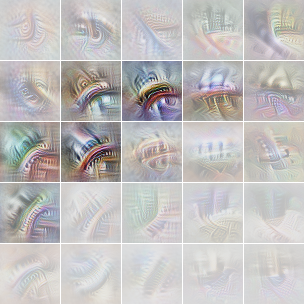

In [ ]:
spatial_visualizations = vis_vecs("mixed3a", 60, W_3a_3b[:,:,:,379])

mags = np.sqrt((W_3a_3b[:,:,:,379]**2).sum(-1))
show(build_img_grid(spatial_visualizations, mags=mags) )

## NMF Visualizations of hidden-hidden weights

In [ ]:
W_3a_3b = get_expanded_weights(model, "mixed3a", "mixed3b")

In [ ]:
# NMF (or other dimensionality) can be an easy way to see spaital structure in weights
# It can be used context free and doesn't need necessarily need feature vis.

# hack to make matrix positive by concatination, allowing us to simulate 
# one-sided NMF with regular NMF
W_3a_3b_posneg = np.concatenate([np.maximum(0, W_3a_3b), np.maximum(0, -W_3a_3b)], axis=2)


W_nmf = ChannelReducer(3).fit_transform(W_3a_3b_posneg[..., 320])
W_nmf /= W_nmf.max()
show(W_nmf, w=70)

In [ ]:
# We can use more than 3 components if we wish

for n_components in range(2, 6):
  W_nmf = ChannelReducer(n_components).fit_transform(W_3a_3b_posneg[..., 320])
  W_nmf /= W_nmf.max()
  show(collapse_channels.collapse_channels(W_nmf), w=70)

In [ ]:
# Of course, it's more interesting to see linked to feature visualizations.

n_components = 3
units = list(range(320, 340))
weight_vis = []
for i in range(320, 340):
  W_nmf = ChannelReducer(n_components).fit_transform(W_3a_3b_posneg[..., i])
  W_nmf /= W_nmf.max()
  weight_vis.append(collapse_channels.collapse_channels(W_nmf))
_display_html(neuron_with_weight_row_preselected("mixed3b", units, weight_vis))



Comonent 0



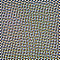



Comonent 1



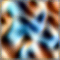

In [ ]:
# NMF is escpecially effective when you can describe multiple related neurons 
# with a small numberr of factors. High-low frequency detectors are a great 
# example of this! The weights have one component corrresponding to high 
# frequency and another to low. (forthcoming paper by Schubert et al)

n_components = 2
highlow_units = [110, 180, 153, 106, 112, 186, 132, 136, 117, 113, 108, 70, 86, 88, 160]
N = len(highlow_units)

# maxpool4 = maxpool(mixed3b) - use it instead to avoid distortion of weights.
W_2d_3a = get_expanded_weights(model, "maxpool1", "mixed3a")

# extract units to study and make them first dim
W_ = W_2d_3a[..., highlow_units].transpose(-1, 0, 1, 2)

# hack to make matrix positive by concatination, allowing us to simulate 
# one-sided NMF with regular NMF. This time the posneg side will be spatial 
# instead of channels
W_posneg = np.concatenate([np.maximum(0, W_), np.maximum(0, -W_)], axis=0)

NMF = ChannelReducer(n_components)
W_nmf = NMF.fit_transform(W_posneg)
W_nmf /= W_nmf.max()
weight_vis = list(collapse_channels.collapse_channels(W_nmf[:N] - W_nmf[N:]))


# We can then visualize the two factors

obj = sum(objectives.direction("conv2d2", NMF.components[i], batch=i) for i in range(n_components))
imgs = render.render_vis(model, obj, param_f=lambda: param.image(60, batch=n_components))[-1]

for i in range(n_components):
  print("\n\nComonent", i)
  show(imgs[i])
  _display_html(neuron_with_weight_row_preselected("mixed3a", highlow_units, [weight_heatmap((W_nmf[:N] - W_nmf[N:])[j, ..., i]) for j in range(N)] ))

512 980.72705



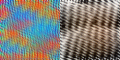



Comonent 0



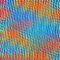



Comonent 1



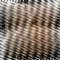

In [ ]:
# BW vs colorr detectors are another good example of this:

n_components = 2
BW_units = [214, 208, 201, 223, 210, 197, 222, 204]
N = len(BW_units)

# maxpool4 = maxpool(mixed3b) - use it instead to avoid distortion of weights.
W_2d_3a = get_expanded_weights(model, "maxpool1", "mixed3a")

# extract units to study and make them first dim
W_ = W_2d_3a[..., BW_units].transpose(-1, 0, 1, 2)

# hack to make matrix positive by concatination, allowing us to simulate 
# one-sided NMF with regular NMF. This time the posneg side will be spatial 
# instead of channels
W_posneg = np.concatenate([np.maximum(0, W_), np.maximum(0, -W_)], axis=0)

NMF = ChannelReducer(n_components)
W_nmf = NMF.fit_transform(W_posneg)
W_nmf /= W_nmf.max()
weight_vis = list(collapse_channels.collapse_channels(W_nmf[:N] - W_nmf[N:]))


# We can then visualize the two factors

obj = sum(objectives.direction("conv2d2", NMF.components[i], batch=i) for i in range(n_components))
imgs = render.render_vis(model, obj, param_f=lambda: param.image(60, batch=n_components))[-1]

for i in range(n_components):
  print("\n\nComonent", i)
  show(imgs[i])
  _display_html(neuron_with_weight_row_preselected("mixed3a", BW_units, [weight_heatmap((W_nmf[:N] - W_nmf[N:])[j, ..., i]) for j in range(N)] ))